In [44]:
import os
from glob import glob
import pandas as pd
import librosa
from librikws import *
import numpy as np
from tslearn.metrics import dtw_path, dtw
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [2]:
keywords=get_unique_keywords()
keywords[:5]

['sixteen fifty', 'the house', 'my son', 'my wife', 'thousand francs']

In [3]:
keyword_row, sentence_row = get_random_keyword_sentence_pair(keywords[0])

In [4]:
keyword, sr = librosa.load(os.path.join(LIBRIPHRASE_DATA, keyword_row['file']))
keyword.shape, sr

((15876,), 22050)

In [7]:
sentence, sr = librosa.load(os.path.join(LIBRISPEECH_ROOT, sentence_row['file']))
sentence.shape, sr

((271989,), 22050)

In [36]:
def get_mfcc_w_deltas(wav):
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc, order=1)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    return np.concatenate([mfcc, mfcc_delta, mfcc_delta2]).T

In [37]:
keyword_mfcc = get_mfcc_w_deltas(keyword)
sentence_mfcc = get_mfcc_w_deltas(sentence)

keyword_mfcc.shape, sentence_mfcc.shape

((32, 39), (532, 39))

/var/folders/bt/_dsrh6ld2yncbnn9vk_d2lcc0000gp/T/ipykernel_94911/2818446551.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


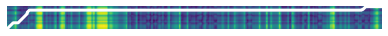

In [43]:
sz=keyword_mfcc.shape[0]
path, sim = dtw_path(keyword_mfcc, sentence_mfcc)

plt.figure(1, figsize=(8, 8))

# definitions for the axes
left, bottom = 0.01, 0.1
w_ts = h_ts = 0.2
left_h = left + w_ts + 0.02
width = height = 0.65
bottom_h = bottom + height + 0.02

rect_s_y = [left, bottom, w_ts, height]
rect_gram = [left_h, bottom, width, height]
rect_s_x = [left_h, bottom_h, width, h_ts]

ax_gram = plt.axes(rect_gram)
# ax_s_x = plt.axes(rect_s_x)
# ax_s_y = plt.axes(rect_s_y)

mat = cdist(keyword_mfcc, sentence_mfcc)

ax_gram.imshow(mat, origin='lower')
ax_gram.axis("off")
ax_gram.autoscale(False)
ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-",
             linewidth=3.)

# ax_s_x.plot(np.arange(sz), sentence_mfcc, "b-", linewidth=3.)
# ax_s_x.axis("off")
# ax_s_x.set_xlim((0, sz - 1))

# ax_s_y.plot(- keyword_mfcc, np.arange(sz), "b-", linewidth=3.)
# ax_s_y.axis("off")
# ax_s_y.set_ylim((0, sz - 1))

plt.tight_layout()
plt.show()

In [65]:
sentence_windows = np.lib.stride_tricks.sliding_window_view(
    sentence_mfcc,
    (keyword_mfcc.shape[0], 39),
    # axis=1,
).squeeze()
sentence_windows.shape

(501, 32, 39)

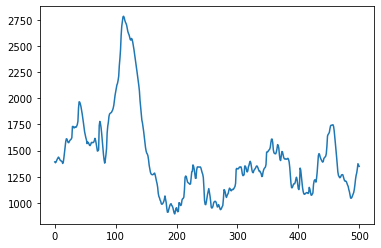

In [68]:
dtw_scores = [
    dtw(sentence_window, keyword_mfcc) for sentence_window in sentence_windows
]
plt.plot(dtw_scores)
plt.show()